# Master-Part Relationships


Master-part relationships express the idea that a given entity (*master*) may include several tightly-coupled component entities (*parts*) spread across multiple tables. 
This notion is also described as *compositional integrity*.

In DataJoint's relational workflow philosophy, a master part relationship expresses the notion of populated multiple related data artifacts in a single workflow step.

For example, a purchase order may include several items that should be treated as indivisible components of the purchase order.
Another example is a measurement from several channels: all must be recorded jointly before any downstream processing can begin.

When inserting or deleting a master entity with all its parts, the database client must do so as a single all-or-nothing (*atomic*) transaction so that the master entity always appears with all its parts.
Creating the master with any of its parts missing would constitute violation of compositional integrity.

## Defining a Master-Part Relationship

Consider the example of a schema describing polygons which are defined by the coordinaates of its vertices. 
Here `Polygon`/`Vertex` is a master-part relationship.

In [2]:
%xmode minimal

import datajoint as dj

schema = dj.Schema('polygons')

@schema 
class Polygon(dj.Manual):
    definition = """
    polygon_id : int
    """

    class Vertex(dj.Part):
        definition = """
        -> master
        vertex_id : int 
        ---
        x : float
        y : float
        """

    # Explicit numeric datatypes such as float32 and uint16 are introduced in DataJoint 2.0.
    # Earlier versions of datajoint-python use native mysql datatypes such as INT and SMALLINT

Exception reporting mode: Minimal


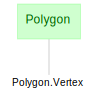

In [3]:
dj.Diagram(schema)

As seen in this example, DataJoint provides special syntax for defining master-part relationships:

1. **Master tables are declared normally** The master entity is declared as any regular table by subclassing `dj.Manual`/`dj.Lookup`/`dj.Imported`/`dj.Computed`. Thus a table becomes a master table by virtue of having part tables.

2. **Nested class definition** – Parts are declared as a nested class inside its master class, subclassing `dj.Part`. Thus the part tables are referred to by their full class name such as `Polygon.Vertex`.  Their classes do not need to be wrapped the the `@schema` decorator: the decorated of the master class is responsible for declaring all of its parts. 

3. **Foreign key from part to master** The part tables declare a foreign key to its master directly or transitively through other parts. Inside the namespace of the master class a special object named `master` can be used to reference to the master table. Thus the definition of the `Vertex` table can declare the foreign key `-> master` as an equivalent alias to `-> Polygon` --- either will form a valid foreign key. 

4. **Diagram notation** – In schema diagrams, part tables are rendered without colored blocks. They appear as labels attached to the master node, emphasizing that they do not stand on their own. The absence of color also highlights that other tables rarely reference parts directly; the master represents the entity identity.

5. **Workflow semantics**

## Master-Part Semantics

The Master-Part relationship indicates to all client applications that inserts into the master and its parts must be done inside a dedicated transactions.

Transactions cannot be nested and neither can master-part relationships. 
A part table cannot be a master table in another relationship.

Parts can only have one master. However, a master table can have 

All parts must declare a foreign key to the master, although they can do so transitively through other parts.

A foreign key made by a downstream table to the master signifies a dependency on the entire collection of all its parts. Therefore, deleting a master entry will naturally cascade to all its parts.

Parts cannot be deleted without deleting their master. Direct deletes of the parts are prohibited. Deleting 

At insert time, DataJoint does not enforce the master-part semantics for manual and lookup tables. The master-part notation only signals to the client applications that they must use transactions when inserting records into masters and their parts.


## Master-Part in Computations

For autopopulated tables, the `populate` mechanism properly handles transactions: each master `make` method is called within an atomic isolated transaction and it populates both the master and the parts. Any error ocurring inside the make method, rolls back the master and the parts already populated within that `make` call. 

See [master-part]() for a detailed explanation of populating master-part entries.

## Workflow semantics

Master-part relationships are most powerful in auto-computed tables (`dj.Computed` or `dj.Imported`). When a master is populated, DataJoint executes the master's `make()` method inside an atomic transaction. This guarantees that all parts belonging to the master are inserted (or updated) together with the master row. If any part fails to insert, the entire transaction is rolled back, preserving consistency.

This workflow semantics offers two key benefits:

- **Atomicity** – From the points of view of other agents accessing the database, every master row is all-or-nothing. Either the master and all its parts appear together, or none of them do. Partially populated entries are only visible from inside transactions that create them. Downstream tables can safely depend on the master row, knowing that its parts are already in place.
- **Isolation** – Any transaction that populates a master and its parts operates on a consistent isolated state of the database. Any changes that ocurr during this transaction will not affect computations of the individual parts. In DataJoint, this is typically already the case if users eschew updates and computations from data outside direct upstream dependencies. 

Because master/part tables are created together, they naturally fit into the [relational workflow model](../20-concepts/04-workflows.md). The master participates in the DAG as a normal node, while the parts are executed inside the same workflow step.

:::{seealso}
For a complete computational example demonstrating master-part relationships in an image analysis pipeline, see the [Blob Detection](../80-examples/075-blob-detection.ipynb) example, where `Detection` (master) and `Detection.Blob` (part) capture aggregate blob counts and per-feature coordinates atomically.
:::

## Practical guidelines

- **Use parts for tightly-coupled detail rows**: If the part data never exists without the master, implement it as a nested part rather than a separate table. Examples include waveform channels, spike units per recording, order lines for a purchase order, or parameter sweeps attached to a model fit.
- **Keep part logic inside `make()`**: Populate the master and insert all parts from within the master’s `make()` method. Do not create separate processes that attempt to fill the part tables independently—the transactional guarantees rely on the nesting.
- **Diagram awareness**: Remember that part nodes appear without colored blocks in the diagram. Use this visual cue to distinguish between independent entity tables and parts. Diagramming utilities provide the option of hiding all parts for a simplified view.


## Summary

Master-part relationships provide a concise and expressive way to model a master record that owns several subordinate rows. DataJoint’s nested class syntax, simplified foreign key, and transactional populate make this pattern easy to express and safe to use. In the context of relational workflows, masters act as workflow nodes, while parts capture the detailed payload generated in the same workflow step.
